# day03 B - Gradient Descent with JAX

In this notebook, we'll practice

* Part 0: Reviewing a simple procedure for gradient descent
* Part 1: Gradient descent for simple multivariate optimization problems
* Part 2: Gradient descent for linear regression

# Requirements

There are two ways to run this notebook

<table style="table-medium">
    <tr>
        <td style="align:left; text-align:left;"> <h2> Run in-browser (no install necessary) </h2>
        </td>
        <td style="align:left; text-align:left;"> <h2> Run locally on your computer </h2>
        </td>        
    </tr>
    <tr>
         <td style="align:left; text-align:left;">
             <p>You can use <a href="https://colab.research.google.com/">Google Colab </a> </p>
             <p>You'll need:</p>
             <ul>
             <li> internet connection </li>
             <li>  Modern browser (Firefox, Chrome, Safari, Edge, etc) </li>
             <li> Google account </li>
             <li> Warning: session will timeout after 12 hours, or sooner if inactive </li>
             <li> Plan to save work if you want it later </li>
         </ul></td>
         <td style="align:left; text-align:left;">
             <p>You can use <a href="https://jupyter.org/">Jupyter notebook </a> </p>
             <p>You'll need:</p>             <ul>
             <li> Linux, Mac OS or other modern Unix-based OS (sorry, Windows + JAX is difficult) </li>
             <li> Conda package manager </li>
             <li> Python 3.8+ </li>
             <li> All packages from <a href="https://www.cs.tufts.edu/comp/152BDL/2022f/bdl_2022f_env.yml">bdl_2022f_env</a> 
                 , see <a href="https://www.cs.tufts.edu/comp/152BDL/2022f/setup_python_env.html">
                 Install Instructions on Course Website </a>
             </li>
         </ul></td>
    </tr>
</table>


In [3]:
# Import numpy for arrays
import numpy as np

# Import pandas for reading/writing tabular data
import pandas as pd

# Import info about the local OS
import os, platform

In [4]:
# Import JAX
import jax.numpy as jnp
import jax

In [5]:
# Import packages for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

### Report OS and CPU information

In [10]:
uname = platform.uname()
B = 10
print("="*B, "Information about OS and CPU", "="*B)
print(f"Node Name: {uname.node}")
print(f"System: {uname.system}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}  Processor: {uname.processor}")
print("Num cores: ", os.cpu_count())

========== Information about OS and CPU ==========
Node Name: Michaels-MacBook-Pro-2.local
System: Darwin
Version: Darwin Kernel Version 20.6.0: Tue Feb 22 21:10:41 PST 2022; root:xnu-7195.141.26~1/RELEASE_X86_64
Machine: x86_64  Processor: i386
Num cores:  8


### Report exact versions of required packages in local environment

In [7]:
print("="*B, "Packages in local env", "="*B)
for pkg in [np, jax, matplotlib, sns]:
  print("%12s %s" % (pkg.__name__, pkg.__version__))

========== Packages in local env ==========
       numpy 1.22.4
         jax 0.3.17
  matplotlib 3.5.2
     seaborn 0.11.2


# Part 0: Simple gradient descent procedure

Recall the basic iterative algorithm for optimizing a given loss function via steps in the direction of "steepest descent". For review, see [Sec. 7.1 of Mathematics for Machine Learning](https://mml-book.github.io/book/mml-book.pdf#page=232)

We'll define a simple Python function to solve optimization problems with this method.

The 5 key inputs are:

* Function to compute the loss
* Function to compute the gradient
* Array specifying a concrete initialization of the variable we're trying to optimize
* Step size 
* Number of iterations to run

**Read thru the code below** to make sure you understand how this works. (For now, you can ignore details related to **printing**, these are useful for logging /debugging but not essential for your first pass understanding).

In [13]:
def run_many_iters_of_grad_descent(
        calc_loss,
        calc_grad,
        init_x_D,
        step_size=0.001,
        n_iters=100,
        print_every=None):
    ''' Run many iterations of gradient descent
    
    Args
    ----
    calc_loss : function
        Computes the loss that we want to minimize
        Maps D-dim input array to scalar
    calc_grad : function
        Computes the gradient (a D-dim array) of loss
        Maps D-dim input array to D-dim grad array
    init_x_D : 1D array, size D
        Initial value of the variable x we're trying to optimize
    
    Returns
    -------
    xopt_D : 1D array, size D
        Final value of vector x, 
        If converged, should be local optima of loss function
    history : dict of lists
        Provides history of the function value
    '''
    # Copy the initial parameter vector, casting to float if needed
    x_D = 1.0 * init_x_D

    # Create data structs to track per-iteration history
    # of different quantities
    history = dict(
        iter=[],
        loss=[],
        x_D=[],
        g_D=[])

    for iter_id in range(n_iters+1):
        if iter_id > 0:
            x_D = x_D - step_size * calc_grad(x_D)

        history['iter'].append(iter_id)
        history['loss'].append(calc_loss(x_D))
        history['x_D'].append(x_D)
        history['g_D'].append(calc_grad(x_D))
        
        if isinstance(print_every, int) and iter_id % print_every == 0:
            print("iter %4d/%d  loss %11.6f" % (
                iter_id, n_iters, history['loss'][-1]))
    return x_D, history

### Concept check:

* Will this procedure always produce a guaranteed optimal value of $x^*$? Explain...
* What could go wrong if `step_size` is set too low?
* What could go wrong if `step_size` is set too high?


# Part 1: Gradient descent on simple multivariate functions

## Worked Example 1A: Minimize f(x) = sum(square(x))

It's easy to figure out that the vector with smallest L2 norm (smallest sum of squares) is the all-zero vector.

Here's a quick example of showing that using gradient functions provided by jax can help us solve the optimization problem:

$$
\min_x  \sum_{d=1}^D x_d^2
$$

In [18]:
# Build the loss function
def calc_loss_sum_of_squares(x_D):
    return jnp.sum(jnp.square(x_D))

# Use JAX to build the grad function
calc_grad_sum_of_squares = jax.grad(calc_loss_sum_of_squares)

In [19]:
# Initialize at x_D = [-3, 4, -5, 6]
init_x_D = np.asarray([-3.0, 4.0, -5.0, 6.0])

In [20]:
opt_x_D, history = run_many_iters_of_grad_descent(
    calc_loss_sum_of_squares,
    calc_grad_sum_of_squares,
    init_x_D, n_iters=500, step_size=0.01, print_every=100)

iter    0/500  loss   86.000000
iter  100/500  loss    1.512563
iter  200/500  loss    0.026603
iter  300/500  loss    0.000468
iter  400/500  loss    0.000008
iter  500/500  loss    0.000000


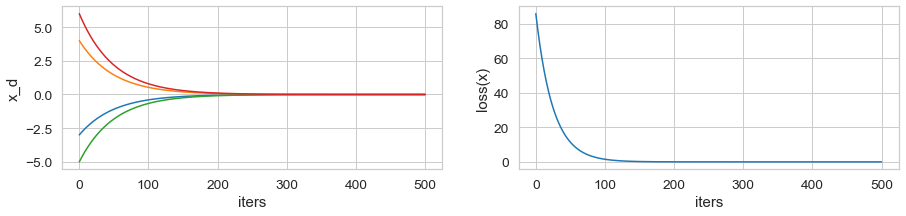

In [21]:
# Make plots of how x parameter values evolve over iterations
# and also how function values evolve over iterations
# Expected result: f goes to zero. all x values goto zero.

fig_h, subplot_grid = plt.subplots(
    nrows=1, ncols=2, sharex=True, sharey=False, figsize=(15,3), squeeze=False)
subplot_grid[0,0].plot(history['iter'], history['x_D'])
subplot_grid[0,0].set_xlabel('iters')
subplot_grid[0,0].set_ylabel('x_d')

subplot_grid[0,1].plot(history['iter'], history['loss'])
subplot_grid[0,1].set_xlabel('iters')
subplot_grid[0,1].set_ylabel('loss(x)');

### Concept check:

* What is happening in the left plot above? Does it make sense in terms of our goals?
* What is happening in the right plot above? Does it make sense in terms of our goals/what we expect?

## Exercise 1B: 

Given a 2-dimensional vector $x = [x_1, x_2]$, the trid function is:

$$
f(x) = (x_1-1)^2 + (x_2-1)^2 - x_1 x_2
$$

Here's a 3D plot, with the value of the function in the z-axis:

<img src="https://www.sfu.ca/~ssurjano/trid.png" width="33%">

Background and Picture credit: <https://www.sfu.ca/~ssurjano/trid.html>

Can you use JAX + gradient descent to find the optimal value $x^*$ that minimizes $f(x)$?

You can initialize your gradient descent at [+1.0, -1.0]

In [23]:
# TODO define your function
def calc_loss_trid(x_D):
    return 0.0 # TODO fixme

In [24]:
# TODO actually compute the gradient of f
calc_grad_trid = calc_loss_trid 

In [25]:
# TODO replace placeholders below
# by calling run_many_iters_of_gradient_descent() with appropriate args
D = 2
opt_x_D = np.zeros(D)
history = dict(iter=np.arange(100), loss=np.zeros(100), x_D=[2*np.arange(D)-1]*100)

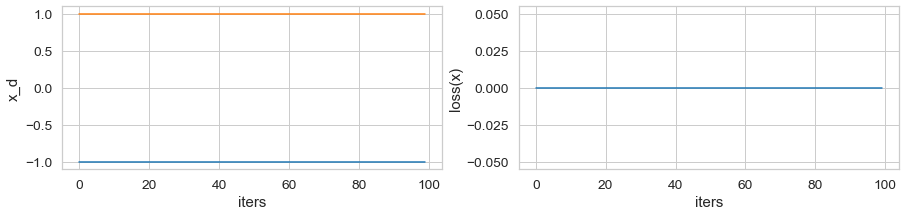

In [26]:
# TRID example
# Make plots of how x parameter values evolve over iterations
# and how loss function of x evolves over iterations

fig_h, subplot_grid = plt.subplots(
    nrows=1, ncols=2, sharex=True, sharey=False, figsize=(15,3), squeeze=False)
subplot_grid[0,0].plot(history['iter'], history['x_D'])
subplot_grid[0,0].set_xlabel('iters')
subplot_grid[0,0].set_ylabel('x_d')

subplot_grid[0,1].plot(history['iter'], history['loss'])
subplot_grid[0,1].set_xlabel('iters')
subplot_grid[0,1].set_ylabel('loss(x)');

### Ideal Solution when initialized at [+1.0, -1.0]

You should get a plot that looks like this, found in the `exercise_solutions/` folder of the [cs152BDL-22f-assignments repo](https://github.com/tufts-ml-courses/cs152BDL-22f-assignments)

<img width="80%" src="https://raw.githubusercontent.com/tufts-ml-courses/cs152BDL-22f-assignments/main/exercise_solutions/day03-B-Exercise1B-solution-11.png">


### Ideal Solution when initialized at [+4.0, +3.0]

<img width="80%" src="https://raw.githubusercontent.com/tufts-ml-courses/cs152BDL-22f-assignments/main/exercise_solutions/day03-B-Exercise1B-solution-43.png">


# Part 2: Solving linear regression with gradient descent

We observe $N$ examples $(x_i, y_i)$ consisting of D-dimensional 'input' vectors $x_i$ and scalar outputs $y_i$.

Consider the multivariate linear regression model:

For each example $n$, from $1, 2, \ldots N$:

\begin{align}
y_n &\sim \mathcal{N}(w^T x_n, \sigma^2),
\end{align}
where we assume $\sigma = 0.1$.

Our goal is, given data, to learn a good value of the weight vector $w \in \mathbb{R}^D$.

One non-Bayesian way to train weights would be to just compute the maximum likelihood solution:

Let our objective $J(w)$ be defined as the per-example negative log likelihood:

\begin{align}
J(w) &= - \frac{1}{N} \log p( \mathbf{y}_{1:N} | \mathbf{x}_{1:N}, \mathbf{w})
\\
    &= - \frac{1}{N} \sum_{n=1}^N \log p(y_n | x_n, \mathbf{w})
\end{align}


## Toy Data for linear regression task

We'll generate data that comes from an idealized linear regression model.

Each example has D=2 dimensions for x.

The first dimension is weighted by +4.2.
The second dimension is weighted by -4.2


In [27]:
N = 300
D = 2
sigma = 0.1

true_w_D = np.asarray([4.2, -4.2])

train_prng = np.random.RandomState(0)
x_ND = train_prng.uniform(low=-5, high=5, size=(N,D))
y_N = np.dot(x_ND, true_w_D) + sigma * train_prng.randn(N)

## Visualization: Pairplots for all possible (x_d, y) combinations

You can clearly see the slopes of the lines:
* x1 vs y plot: slope is around +4
* x2 vs y plot: slope is around -4

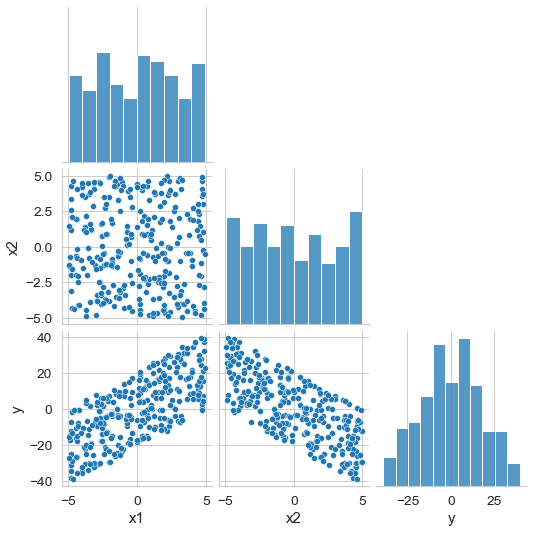

In [28]:
data_df = pd.DataFrame(
        np.hstack([x_ND, y_N[:,np.newaxis]]),
        columns=['x1', 'x2', 'y'])
sns.pairplot(data=data_df, corner=True);

## Worked Example 2A: Fitting linear model to toy data

In [33]:
# Define the objective as an GRAD-able function wrt the weights w_D
def calc_neg_likelihood_linreg(w_D):
    yhat_N = jnp.dot(x_ND, w_D)
    return 0.5 / jnp.square(sigma) * jnp.mean(jnp.square(yhat_N - y_N))

In [34]:
## Test the loss function at an easy all-zero input vector
w_allzero_D = np.zeros(2)
calc_neg_likelihood_linreg(w_allzero_D)

DeviceArray(15497.727, dtype=float32)

In [35]:
calc_grad_wrt_w = jax.grad(calc_neg_likelihood_linreg)

In [36]:
## Test the gradient at that easy all-zero vector 
calc_grad_wrt_w(w_allzero_D)

DeviceArray([-3511.609,  3864.746], dtype=float32)

In [37]:
# Because the gradient's magnitude is very large, use very small step size
opt_w_D, history = run_many_iters_of_grad_descent(
    calc_neg_likelihood_linreg,
    calc_grad_wrt_w,
    w_allzero_D,
    n_iters=300, step_size=0.0001, print_every=20,
    )

iter    0/300  loss 15497.726562
iter   20/300  loss  396.549255
iter   40/300  loss   11.042154
iter   60/300  loss    0.830816
iter   80/300  loss    0.549395
iter  100/300  loss    0.541326
iter  120/300  loss    0.541087
iter  140/300  loss    0.541079
iter  160/300  loss    0.541079
iter  180/300  loss    0.541079
iter  200/300  loss    0.541079
iter  220/300  loss    0.541079
iter  240/300  loss    0.541079
iter  260/300  loss    0.541079
iter  280/300  loss    0.541079
iter  300/300  loss    0.541079


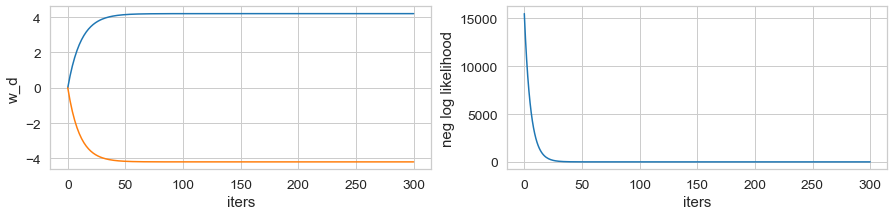

In [38]:
# LinReg worked example
# Make plots of how w_D parameter values evolve over iterations, and function values evolve over iterations
# Expected result: x

fig_h, subplot_grid = plt.subplots(
    nrows=1, ncols=2, sharex=True, sharey=False, figsize=(15,3), squeeze=False)
subplot_grid[0,0].plot(history['iter'], history['x_D'])
subplot_grid[0,0].set_xlabel('iters')
subplot_grid[0,0].set_ylabel('w_d')

subplot_grid[0,1].plot(history['iter'], history['loss'])
subplot_grid[0,1].set_xlabel('iters')
subplot_grid[0,1].set_ylabel('neg log likelihood');

### Concept check:

* What is happening in the left plot above? Does it make sense in terms of our goals?
* What is happening in the right plot above? Does it make sense in terms of our goals/what we expect?
* Would you recommend a different `step_size` or `n_iters` based on these plots? Why?